In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive/', force_remount=True)
!unzip -q /content/gdrive/MyDrive/Dataset.zip

Mounted at /content/gdrive/


In [3]:
image_list = [
    os.path.join(dirname, filename)
    for dirname, _, filenames in os.walk("Dataset")
    for filename in filenames
    if ".jpg" in filename
]

In [4]:
chihuahua_images = [img for img in image_list if "chihuahua" in img]
muffin_images = [img for img in image_list if "muffin" in img]
cnt_chihuahua = len(chihuahua_images)
cnt_muffin = len(muffin_images)
print(cnt_chihuahua)
print(cnt_muffin)

3199
2718


In [5]:
import pandas as pd

In [6]:

labels = [os.path.basename(os.path.dirname(img)) for img in image_list]
filepaths = [img for img in image_list]
df = pd.DataFrame({"file":filepaths, "label":labels})

In [7]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df, test_size=0.2, random_state=100)
train, val = train_test_split(train_val, test_size=0.125, random_state=100)

print("Training set:", len(train))
print("Validation set:", len(val))
print("Test set:", len(test))

Training set: 4141
Validation set: 592
Test set: 1184


In [8]:
df

,file,label
0,Dataset/muffin/img_2_255.jpg,muffin
1,Dataset/muffin/img_1_284.jpg,muffin
2,Dataset/muffin/img_0_1080.jpg,muffin
3,Dataset/muffin/img_2_318.jpg,muffin
4,Dataset/muffin/img_3_643.jpg,muffin
...,...,...
5912,Dataset/chihuahua/img_4_151.jpg,chihuahua
5913,Dataset/chihuahua/img_2_56.jpg,chihuahua
5914,Dataset/chihuahua/img_3_835.jpg,chihuahua
5915,Dataset/chihuahua/img_3_15.jpg,chihuahua


In [9]:
# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 16

train_gen = datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content",
    x_col="file",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    seed=100,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val,
    directory="/content",
    x_col="file",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    seed=100,
    shuffle=True
)


Found 4141 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.


In [10]:
test_gen = datagen.flow_from_dataframe(
            dataframe = test,
            directory = "/content",
            seed = 100,
            x_col = "file",
            y_col = "label",
            target_size = (224,224),
            class_mode="binary",
            color_mode = "rgb",
            shuffle=False)

Found 1184 validated image filenames belonging to 2 classes.


In [11]:
print("Training set:", len(train))
print("Validation set:", len(val))
print("Test set:", len(test))

Training set: 4141
Validation set: 592
Test set: 1184


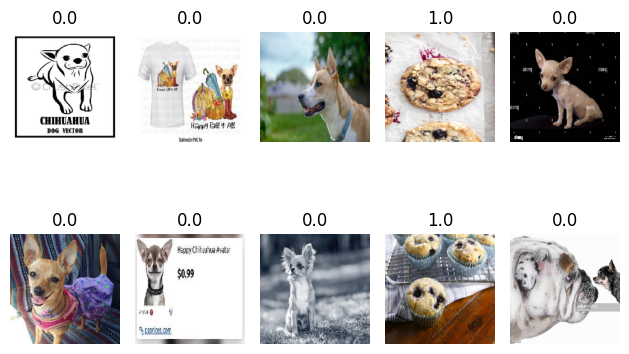

In [12]:
images, labels = train_gen.next()

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Data Augmentation**

In [13]:
aug = ImageDataGenerator(rescale=1. / 255, rotation_range=12, width_shift_range=0.4, height_shift_range=0.2, shear_range=0.1, zoom_range=0.2,
    channel_shift_range=15., horizontal_flip=True)

train_gen_aug = aug.flow_from_dataframe(
    dataframe=train,
    x_col="file",
    y_col="label",
    directory="/content",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    color_mode='rgb',
    seed=100,
    shuffle = True
)

val_gen_aug = aug.flow_from_dataframe(
    dataframe=val,
    x_col="file",
    y_col="label",
    directory="/content",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    color_mode='rgb',
    seed=100,
    shuffle = True
)

Found 4141 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.


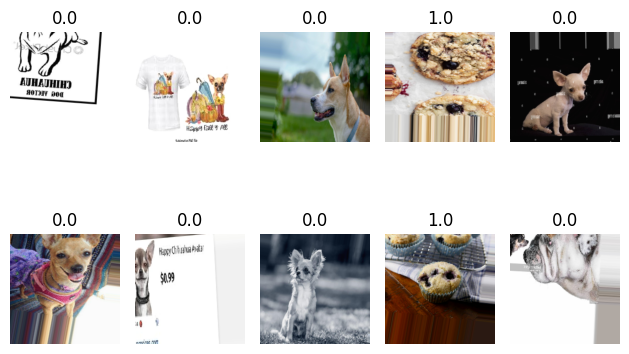

In [14]:
images, labels = train_gen_aug.next()

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5,  start_from_epoch= 15)]

# **First Model**


In [16]:
from keras.layers import MaxPooling2D

In [17]:
FirstModel = Sequential([

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(units = 64, activation = 'relu'),

    Dense(units=1, activation='sigmoid')
])

In [18]:
FirstModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [19]:
#https://deeplizard.com/learn/video/daovGOlMbT4
FirstModel.compile(optimizer = "adam",
                   loss = "binary_crossentropy",
                   metrics = ["accuracy"])

In [20]:
train_steps = len(train) // batch_size
val_steps = len(val) // batch_size

In [21]:
history1 = FirstModel.fit(x=train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks = stop_early,
    steps_per_epoch = min(train_steps, 200)
)
metrics_df1 = pd.DataFrame(history1.history)

Epoch 1/50
200/200 [==============================] - 22s 89ms/step - loss: 0.6449 - accuracy: 0.6925 - val_loss: 0.4283 - val_accuracy: 0.8142
Epoch 2/50
200/200 [==============================] - 18s 88ms/step - loss: 0.3900 - accuracy: 0.8334 - val_loss: 0.3488 - val_accuracy: 0.8615
Epoch 3/50
200/200 [==============================] - 18s 88ms/step - loss: 0.2532 - accuracy: 0.8980 - val_loss: 0.3336 - val_accuracy: 0.8581
Epoch 4/50
200/200 [==============================] - 17s 86ms/step - loss: 0.1621 - accuracy: 0.9390 - val_loss: 0.3076 - val_accuracy: 0.8682
Epoch 5/50
200/200 [==============================] - 18s 89ms/step - loss: 0.0829 - accuracy: 0.9684 - val_loss: 0.3764 - val_accuracy: 0.8699
Epoch 6/50
200/200 [==============================] - 18s 90ms/step - loss: 0.0729 - accuracy: 0.9740 - val_loss: 0.4212 - val_accuracy: 0.8564
Epoch 7/50
200/200 [==============================] - 18s 88ms/step - loss: 0.0310 - accuracy: 0.9894 - val_loss: 0.4845 - val_accuracy:

In [22]:
metrics_df1

,loss,accuracy,val_loss,val_accuracy
0,0.644882,0.692524,0.428330,0.814189
1,0.390006,0.833438,0.348818,0.861486
2,0.253186,0.898029,0.333619,0.858108
3,0.162107,0.939005,0.307613,0.868243
4,0.082871,0.968408,0.376399,0.869932
5,0.072904,0.974038,0.421205,0.856419
6,0.031020,0.989365,0.484463,0.847973
7,0.019058,0.994682,0.549734,0.864865
8,0.019979,0.995308,0.563875,0.866554
9,0.011925,0.996872,0.586496,0.861486


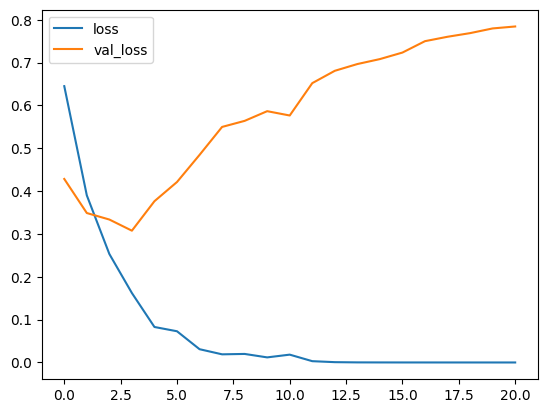

In [23]:
metrics_df1[["loss","val_loss"]].plot();

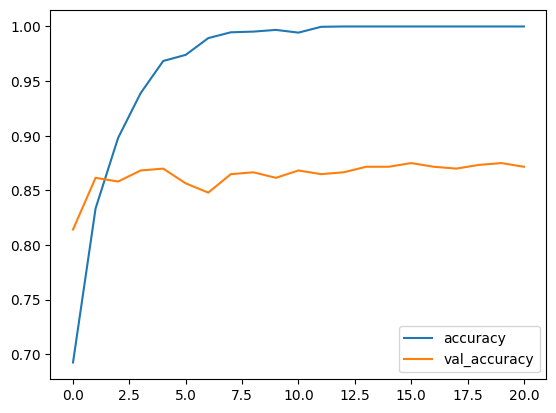

In [24]:
metrics_df1[["accuracy","val_accuracy"]].plot();

# **Second Model**

In [25]:


SecondModel = Sequential([

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(units = 64, activation = 'relu'),

    Dense(units=1, activation='sigmoid')
])

In [26]:
SecondModel.compile(optimizer = "adam",
                   loss = "binary_crossentropy",
                   metrics = ["accuracy"])


In [28]:
history2 = SecondModel.fit(x=train_gen_aug,
    validation_data=val_gen_aug,
    epochs=50,
    callbacks = stop_early,
    #steps_per_epoch = min(train_steps, 200)

)

metrics_df2 = pd.DataFrame(history2.history)

Epoch 1/50
259/259 [==============================] - 71s 270ms/step - loss: 0.8752 - accuracy: 0.6315 - val_loss: 0.5368 - val_accuracy: 0.7618
Epoch 2/50
259/259 [==============================] - 70s 269ms/step - loss: 0.5053 - accuracy: 0.7687 - val_loss: 0.4305 - val_accuracy: 0.8108
Epoch 3/50
259/259 [==============================] - 70s 270ms/step - loss: 0.4283 - accuracy: 0.8092 - val_loss: 0.4005 - val_accuracy: 0.8328
Epoch 4/50
259/259 [==============================] - 69s 266ms/step - loss: 0.4085 - accuracy: 0.8170 - val_loss: 0.4305 - val_accuracy: 0.7956
Epoch 5/50
259/259 [==============================] - 70s 269ms/step - loss: 0.4017 - accuracy: 0.8305 - val_loss: 0.4224 - val_accuracy: 0.8294
Epoch 6/50
259/259 [==============================] - 69s 268ms/step - loss: 0.3907 - accuracy: 0.8317 - val_loss: 0.3471 - val_accuracy: 0.8463
Epoch 7/50
259/259 [==============================] - 69s 267ms/step - loss: 0.3805 - accuracy: 0.8336 - val_loss: 0.3500 - val_ac

In [30]:
metrics_df2

,loss,accuracy,val_loss,val_accuracy
0,0.875151,0.631490,0.536832,0.761824
1,0.505335,0.768655,0.430487,0.810811
2,0.428282,0.809225,0.400546,0.832770
3,0.408507,0.816952,0.430522,0.795608
4,0.401731,0.830476,0.422429,0.829392
5,0.390707,0.831683,0.347066,0.846284
6,0.380461,0.833615,0.350034,0.861486
7,0.357731,0.845931,0.320246,0.859797
8,0.356033,0.847380,0.303044,0.873311
9,0.333381,0.859696,0.339611,0.844595


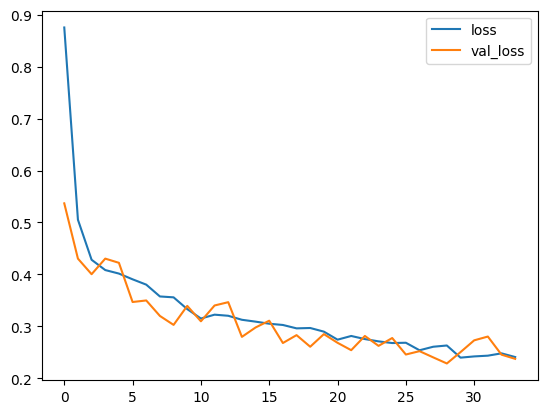

In [31]:
metrics_df2[["loss","val_loss"]].plot();

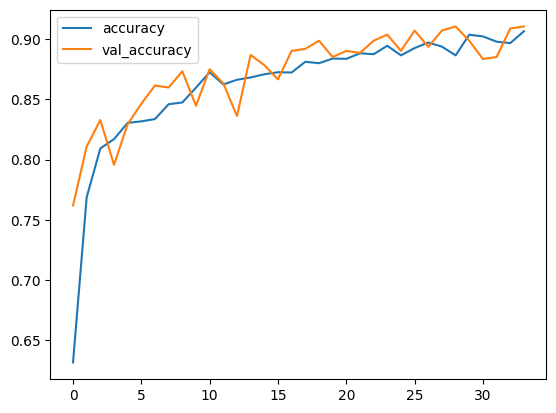

In [32]:
metrics_df2[["accuracy","val_accuracy"]].plot();

# **Third Model**

In [33]:
ThirdModel = Sequential([

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),

    Flatten(),
    Dense(units = 64, activation = 'relu'),
    Dropout(0.3),

    Dense(units=1, activation='sigmoid')
])

ThirdModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)       

In [34]:
ThirdModel.compile(optimizer = "adam",
                   loss = "binary_crossentropy",
                   metrics = ["accuracy"])

In [35]:
history3 = ThirdModel.fit(x=train_gen_aug,
    validation_data=val_gen_aug,
    epochs=50,
    callbacks=stop_early,
    #steps_per_epoch = min(train_steps, 200)
)

metrics_df3 = pd.DataFrame(history3.history)

Epoch 1/50
259/259 [==============================] - 72s 266ms/step - loss: 0.8356 - accuracy: 0.6025 - val_loss: 0.6011 - val_accuracy: 0.7179
Epoch 2/50
259/259 [==============================] - 70s 269ms/step - loss: 0.5951 - accuracy: 0.6873 - val_loss: 0.5897 - val_accuracy: 0.7770
Epoch 3/50
259/259 [==============================] - 69s 268ms/step - loss: 0.5816 - accuracy: 0.7037 - val_loss: 0.5430 - val_accuracy: 0.7635
Epoch 4/50
259/259 [==============================] - 69s 268ms/step - loss: 0.5436 - accuracy: 0.7522 - val_loss: 0.4721 - val_accuracy: 0.8074
Epoch 5/50
259/259 [==============================] - 70s 268ms/step - loss: 0.5238 - accuracy: 0.7619 - val_loss: 0.4578 - val_accuracy: 0.8057
Epoch 6/50
259/259 [==============================] - 69s 266ms/step - loss: 0.5003 - accuracy: 0.7827 - val_loss: 0.4374 - val_accuracy: 0.8378
Epoch 7/50
259/259 [==============================] - 69s 268ms/step - loss: 0.4816 - accuracy: 0.7911 - val_loss: 0.4370 - val_ac

In [36]:
metrics_df3

,loss,accuracy,val_loss,val_accuracy
0,0.835642,0.602511,0.601140,0.717905
1,0.595137,0.687274,0.589664,0.777027
2,0.581627,0.703695,0.542981,0.763514
3,0.543649,0.752234,0.472082,0.807432
4,0.523838,0.761893,0.457845,0.805743
5,0.500292,0.782661,0.437445,0.837838
6,0.481603,0.791113,0.436990,0.829392
7,0.478675,0.799082,0.443050,0.815878
8,0.467197,0.797392,0.404120,0.837838
9,0.444181,0.815262,0.379508,0.844595


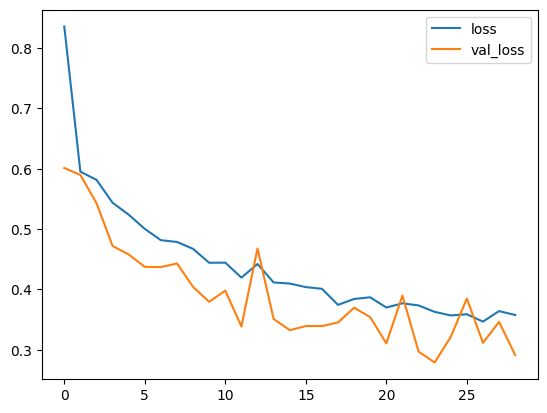

In [37]:
metrics_df3[["loss","val_loss"]].plot();

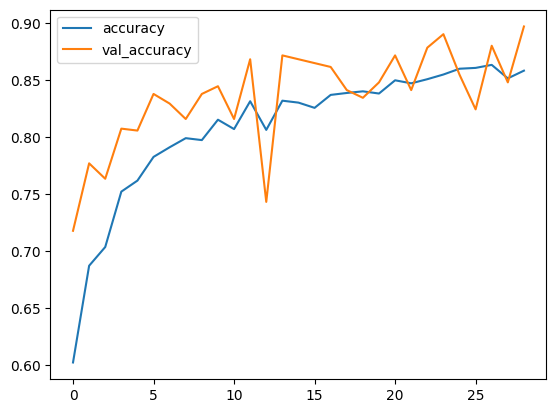

In [38]:
metrics_df3[["accuracy","val_accuracy"]].plot();

# **Fourth Model**

In [39]:
model4 = Sequential([

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),


    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),


    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),


    Flatten(),
    Dense(units = 64, activation = 'relu'),
    Dropout(0.3),

    Dense(units=1, activation='sigmoid')
])

In [40]:
model4.compile(optimizer = "adam",
                   loss = "binary_crossentropy",
                   metrics = ["accuracy"])

In [41]:

history4 = model4.fit(x=train_gen_aug,
    validation_data=val_gen_aug,
    epochs=50,
    callbacks=stop_early
)

metrics_df4 = pd.DataFrame(history4.history)

Epoch 1/50
259/259 [==============================] - 72s 270ms/step - loss: 0.8592 - accuracy: 0.5431 - val_loss: 0.6879 - val_accuracy: 0.5591
Epoch 2/50
259/259 [==============================] - 70s 270ms/step - loss: 0.6892 - accuracy: 0.5462 - val_loss: 0.6866 - val_accuracy: 0.5591
Epoch 3/50
259/259 [==============================] - 70s 270ms/step - loss: 0.6897 - accuracy: 0.5462 - val_loss: 0.6868 - val_accuracy: 0.5591
Epoch 4/50
259/259 [==============================] - 69s 267ms/step - loss: 0.6890 - accuracy: 0.5462 - val_loss: 0.6863 - val_accuracy: 0.5591
Epoch 5/50
259/259 [==============================] - 69s 268ms/step - loss: 0.6890 - accuracy: 0.5462 - val_loss: 0.6864 - val_accuracy: 0.5591
Epoch 6/50
259/259 [==============================] - 69s 266ms/step - loss: 0.6878 - accuracy: 0.5528 - val_loss: 0.6505 - val_accuracy: 0.7500
Epoch 7/50
259/259 [==============================] - 69s 265ms/step - loss: 0.5800 - accuracy: 0.7208 - val_loss: 0.5331 - val_ac

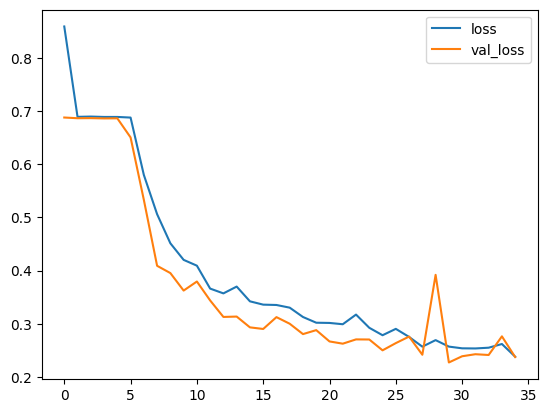

In [43]:
metrics_df4[["loss","val_loss"]].plot();

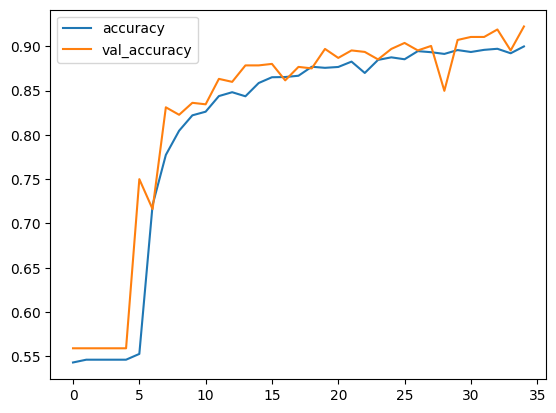

In [44]:
metrics_df4[["accuracy","val_accuracy"]].plot();

Hyper Parameter tuning


In [42]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [45]:
def model_builder(hp):
    hidden_dropout = hp.Float("dropout_hidden_layer", min_value = 0.05, max_value = 0.3, step = 0.05)
    dense_dropout = hp.Float("dropout_flatten_layer", min_value = 0.2, max_value = 0.5, step = 0.1)

    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=hp.Int("convolution_1_filters", min_value=16, max_value=64, step=16),
                                  kernel_size=(3, 3),
                                  input_shape=(224, 224, 3)))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hidden_dropout))


    model.add(keras.layers.Conv2D(filters=hp.Int("convolution_2_filters", min_value=32, max_value=128, step=32),
                                  kernel_size=(3, 3)))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hidden_dropout))



    model.add(keras.layers.Conv2D(filters=hp.Int("convolution_3_filters", min_value=64, max_value=256, step=64),
                                  kernel_size=(3, 3)))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hidden_dropout))



    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=hp.Int("num_units", min_value=32, max_value=256, step=32),
                                 activation="relu"))
    model.add(Dropout(dense_dropout))



    model.add(keras.layers.Dense(units=1, activation="sigmoid"))


    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [46]:
tuner = kt.BayesianOptimization(model_builder, objective = "val_accuracy", max_trials = 3,
                                directory = "./gdrive/MyDrive/Muffin&Chihuahua",
                                project_name = "cnn",
                                overwrite = False)

Reloading Tuner from ./gdrive/MyDrive/Muffin&Chihuahua/cnn/tuner0.json


In [47]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
dropout_hidden_layer (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
dropout_flatten_layer (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
convolution_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
convolution_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
convolution_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}


In [48]:
tuner.search(train_gen_aug, epochs = 50, validation_data = val_gen_aug,
             callbacks = stop_early, #steps_per_epoch = min(train_steps, 200)
             )

In [49]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [50]:
best_hyperparameters.values

{'dropout_hidden_layer': 0.05,
 'dropout_flatten_layer': 0.4,
 'convolution_1_filters': 48,
 'convolution_2_filters': 96,
 'convolution_3_filters': 192,
 'num_units': 224}

In [51]:
hypermodel = tuner.hypermodel.build(best_hyperparameters)

In [52]:
history_best = hypermodel.fit(train_gen_aug,
                         epochs = 50,
                         validation_data = val_gen_aug,

                         callbacks=stop_early
)
metrics_df = pd.DataFrame(history_best.history)

Epoch 1/50
259/259 [==============================] - 73s 269ms/step - loss: 0.7186 - accuracy: 0.6636 - val_loss: 0.5387 - val_accuracy: 0.7669
Epoch 2/50
259/259 [==============================] - 69s 268ms/step - loss: 0.5071 - accuracy: 0.7745 - val_loss: 0.4240 - val_accuracy: 0.8091
Epoch 3/50
259/259 [==============================] - 69s 267ms/step - loss: 0.4513 - accuracy: 0.8054 - val_loss: 0.3898 - val_accuracy: 0.8311
Epoch 4/50
259/259 [==============================] - 69s 266ms/step - loss: 0.3934 - accuracy: 0.8302 - val_loss: 0.3535 - val_accuracy: 0.8446
Epoch 5/50
259/259 [==============================] - 69s 266ms/step - loss: 0.3789 - accuracy: 0.8397 - val_loss: 0.3386 - val_accuracy: 0.8666
Epoch 6/50
259/259 [==============================] - 70s 270ms/step - loss: 0.3531 - accuracy: 0.8517 - val_loss: 0.3081 - val_accuracy: 0.8818
Epoch 7/50
259/259 [==============================] - 70s 270ms/step - loss: 0.3428 - accuracy: 0.8616 - val_loss: 0.2572 - val_ac

In [53]:
metrics_df = pd.DataFrame(history_best.history)

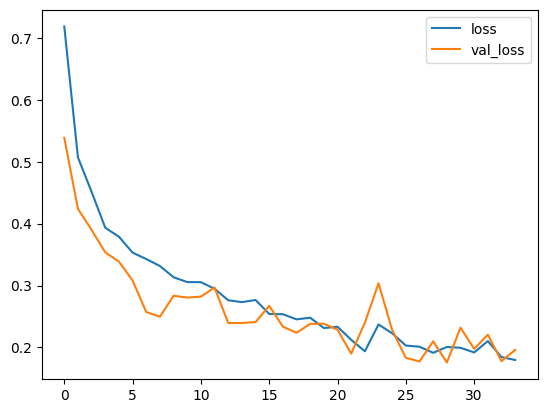

In [54]:
metrics_df[["loss","val_loss"]].plot();

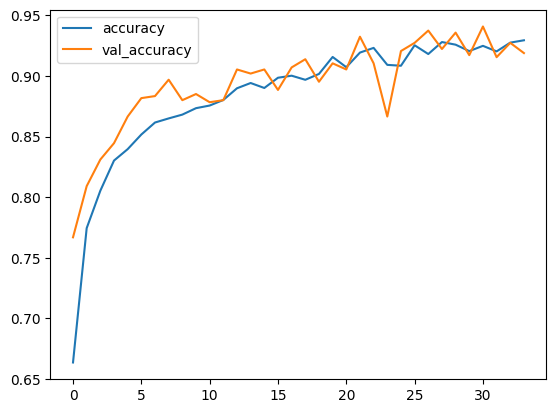

In [55]:
metrics_df[["accuracy","val_accuracy"]].plot();

# **Predictions**

In [56]:
pred = hypermodel.predict(test_gen)

37/37 [==============================] - 6s 150ms/step


In [57]:
pred

array([[0.35806146],
       [0.9998022 ],
       [0.01145652],
       ...,
       [0.09985033],
       [0.9999881 ],
       [0.99999166]], dtype=float32)

In [58]:
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
pred_r = [0 if val < 0.5 else 1 for val in pred]

In [59]:
from sklearn import metrics
report = metrics.classification_report(true_classes, pred_r, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

   chihuahua       0.90      0.96      0.93       606
      muffin       0.95      0.89      0.92       578

    accuracy                           0.93      1184
   macro avg       0.93      0.93      0.93      1184
weighted avg       0.93      0.93      0.93      1184



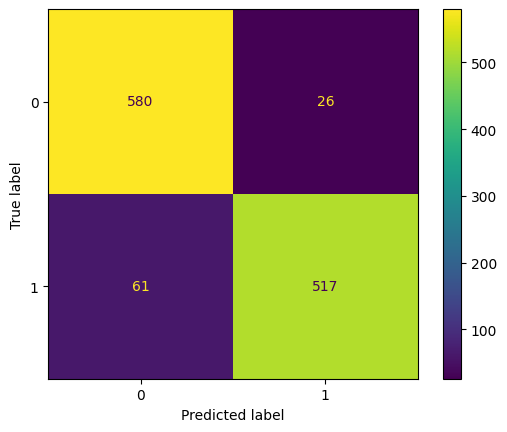

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(true_classes, pred_r)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()

In [61]:
hypermodel.evaluate(test_gen)

37/37 [==============================] - 6s 151ms/step - loss: 0.2306 - accuracy: 0.9265


[0.23058190941810608, 0.9265202879905701]

ROC AUC: 0.970046


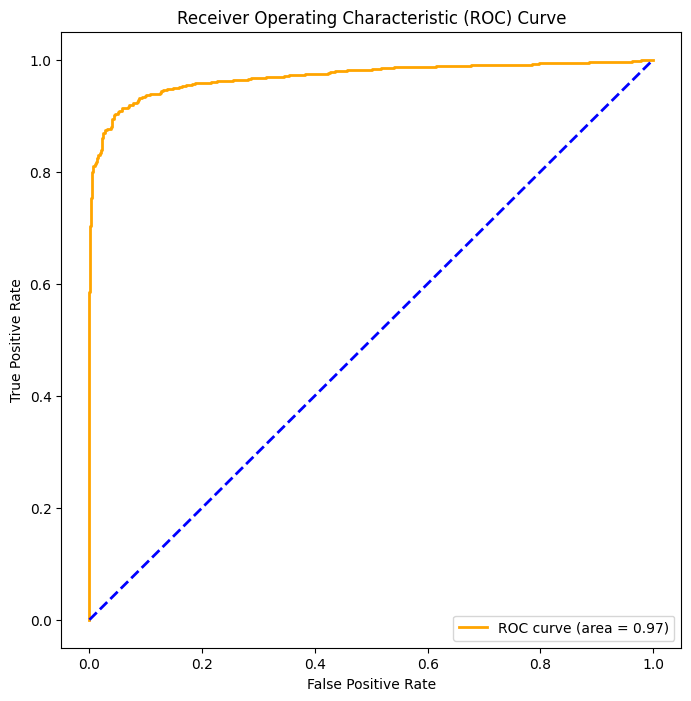

In [62]:
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = metrics.roc_curve(true_classes, pred)

auc = roc_auc_score(true_classes,pred)
print('ROC AUC: %f' % auc)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# **5 Fold Cross Validation**

In [63]:
from sklearn.model_selection import KFold

Y = train[['label']]
kf = KFold(n_splits = 5, random_state = 100, shuffle = True)

In [64]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [65]:
from sklearn.metrics import accuracy_score

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
fold_var = 1

for train_index, val_index in kf.split(df):
    training = df["file"][train_index]
    validation = df["file"][val_index]
    train_df = df.loc[df["file"].isin(training)]
    val_df = df.loc[df["file"].isin(validation)]
    train_data_generator = aug.flow_from_dataframe(train_df, directory="/content",
                                                   x_col="file", y_col="label",
                                                   class_mode="binary", shuffle=True, seed=100,
                                                   target_size=(224, 224))
    valid_data_generator = aug.flow_from_dataframe(val_df, directory="/content",
                                                   x_col="file", y_col="label",
                                                   class_mode="binary", shuffle=False, seed=100,
                                                   target_size=(224, 224))
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hyperparameters)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # FIT THE MODEL
    history = model.fit(train_data_generator,
                        epochs=50,
                        callbacks=stop_early,
                        validation_data=valid_data_generator)

    # SAVE BEST MODEL
    model_path = "/content/Muffin&Chihuahua/model_" + str(fold_var) + ".h5"
    model.save(model_path)

    # LOAD BEST MODEL to evaluate the performance of the model
    if os.path.exists(model_path):
        model.load_weights(model_path)
    else:
        print("File doesn't exist")

    # Get the true labels from the validation data generator
    y_true = valid_data_generator.classes

    # Predict the probabilities using the loaded model
    y_pred_prob = model.predict(valid_data_generator)

    # Convert the probabilities to class labels
    y_pred = np.round(y_pred_prob).flatten()

    # Calculate the accuracy and 0-1 loss
    accuracy = accuracy_score(y_true, y_pred)
    zero_one_loss_value = 1 - accuracy

    VALIDATION_ACCURACY.append(accuracy)
    VALIDATION_LOSS.append(zero_one_loss_value)

    tf.keras.backend.clear_session()
    fold_var += 1

Found 4733 validated image filenames belonging to 2 classes.
Found 1184 validated image filenames belonging to 2 classes.
Epoch 1/50
148/148 [==============================] - 93s 596ms/step - loss: 0.6444 - accuracy: 0.6793 - val_loss: 0.4629 - val_accuracy: 0.8184
Epoch 2/50
148/148 [==============================] - 87s 591ms/step - loss: 0.4596 - accuracy: 0.7921 - val_loss: 0.4087 - val_accuracy: 0.8319
Epoch 3/50
148/148 [==============================] - 86s 580ms/step - loss: 0.4580 - accuracy: 0.8012 - val_loss: 0.7404 - val_accuracy: 0.5845
Epoch 4/50
148/148 [==============================] - 86s 582ms/step - loss: 0.4206 - accuracy: 0.8200 - val_loss: 0.3771 - val_accuracy: 0.8488
Epoch 5/50
148/148 [==============================] - 86s 582ms/step - loss: 0.3749 - accuracy: 0.8430 - val_loss: 0.3210 - val_accuracy: 0.8657
Epoch 6/50
148/148 [==============================] - 87s 585ms/step - loss: 0.3677 - accuracy: 0.8405 - val_loss: 0.3055 - val_accuracy: 0.8818
Epoch 7/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 18s 479ms/step
Found 4733 validated image filenames belonging to 2 classes.
Found 1184 validated image filenames belonging to 2 classes.
Epoch 1/50
148/148 [==============================] - 88s 588ms/step - loss: 0.7756 - accuracy: 0.6034 - val_loss: 0.5795 - val_accuracy: 0.7154
Epoch 2/50
148/148 [==============================] - 87s 588ms/step - loss: 0.4999 - accuracy: 0.7739 - val_loss: 0.4400 - val_accuracy: 0.8209
Epoch 3/50
148/148 [==============================] - 87s 588ms/step - loss: 0.4582 - accuracy: 0.8044 - val_loss: 0.4223 - val_accuracy: 0.8294
Epoch 4/50
148/148 [==============================] - 87s 590ms/step - loss: 0.4256 - accuracy: 0.8177 - val_loss: 0.4225 - val_accuracy: 0.8218
Epoch 5/50
148/148 [==============================] - 87s 587ms/step - loss: 0.3638 - accuracy: 0.8483 - val_loss: 0.3776 - val_accuracy: 0.8590
Epoch 6/50
148/148 [==============================] - 87s 587ms/step - loss: 0.3486 - accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 18s 478ms/step
Found 4734 validated image filenames belonging to 2 classes.
Found 1183 validated image filenames belonging to 2 classes.
Epoch 1/50
148/148 [==============================] - 90s 599ms/step - loss: 0.7296 - accuracy: 0.6694 - val_loss: 0.5135 - val_accuracy: 0.7878
Epoch 2/50
148/148 [==============================] - 87s 586ms/step - loss: 0.5031 - accuracy: 0.7736 - val_loss: 0.4542 - val_accuracy: 0.8242
Epoch 3/50
148/148 [==============================] - 87s 591ms/step - loss: 0.4509 - accuracy: 0.8048 - val_loss: 0.3527 - val_accuracy: 0.8546
Epoch 4/50
148/148 [==============================] - 87s 587ms/step - loss: 0.4106 - accuracy: 0.8245 - val_loss: 0.3263 - val_accuracy: 0.8690
Epoch 5/50
148/148 [==============================] - 87s 588ms/step - loss: 0.3882 - accuracy: 0.8321 - val_loss: 0.3232 - val_accuracy: 0.8631
Epoch 6/50
148/148 [==============================] - 87s 587ms/step - loss: 0.3687 - accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 17s 459ms/step
Found 4734 validated image filenames belonging to 2 classes.
Found 1183 validated image filenames belonging to 2 classes.
Epoch 1/50
148/148 [==============================] - 89s 589ms/step - loss: 0.7483 - accuracy: 0.5321 - val_loss: 0.6854 - val_accuracy: 0.5638
Epoch 2/50
148/148 [==============================] - 87s 589ms/step - loss: 0.6891 - accuracy: 0.5349 - val_loss: 0.6811 - val_accuracy: 0.5638
Epoch 3/50
148/148 [==============================] - 87s 589ms/step - loss: 0.6855 - accuracy: 0.5336 - val_loss: 0.6776 - val_accuracy: 0.5630
Epoch 4/50
148/148 [==============================] - 87s 591ms/step - loss: 0.6933 - accuracy: 0.5321 - val_loss: 0.6883 - val_accuracy: 0.5638
Epoch 5/50
148/148 [==============================] - 88s 593ms/step - loss: 0.6909 - accuracy: 0.5349 - val_loss: 0.6847 - val_accuracy: 0.5638
Epoch 6/50
148/148 [==============================] - 89s 600ms/step - loss: 0.6891 - accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 18s 474ms/step
Found 4734 validated image filenames belonging to 2 classes.
Found 1183 validated image filenames belonging to 2 classes.
Epoch 1/50
148/148 [==============================] - 89s 587ms/step - loss: 0.7750 - accuracy: 0.5370 - val_loss: 0.6755 - val_accuracy: 0.5545
Epoch 2/50
148/148 [==============================] - 87s 587ms/step - loss: 0.6118 - accuracy: 0.6652 - val_loss: 0.4913 - val_accuracy: 0.7811
Epoch 3/50
148/148 [==============================] - 87s 589ms/step - loss: 0.4567 - accuracy: 0.8048 - val_loss: 0.4754 - val_accuracy: 0.7642
Epoch 4/50
148/148 [==============================] - 87s 588ms/step - loss: 0.4077 - accuracy: 0.8302 - val_loss: 0.3679 - val_accuracy: 0.8495
Epoch 5/50
148/148 [==============================] - 87s 591ms/step - loss: 0.3806 - accuracy: 0.8376 - val_loss: 0.3166 - val_accuracy: 0.8707
Epoch 6/50
148/148 [==============================] - 87s 588ms/step - loss: 0.3586 - accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 17s 454ms/step


In [66]:
VALIDATION_ACCURACY

[0.950168918918919,
 0.8800675675675675,
 0.9340659340659341,
 0.5638207945900253,
 0.9137785291631445]

In [67]:
np.mean(VALIDATION_ACCURACY)

0.848380348861118

In [68]:
VALIDATION_LOSS

[0.04983108108108103,
 0.11993243243243246,
 0.06593406593406592,
 0.4361792054099747,
 0.0862214708368555]

In [69]:
np.mean(VALIDATION_LOSS)

0.15161965113888193

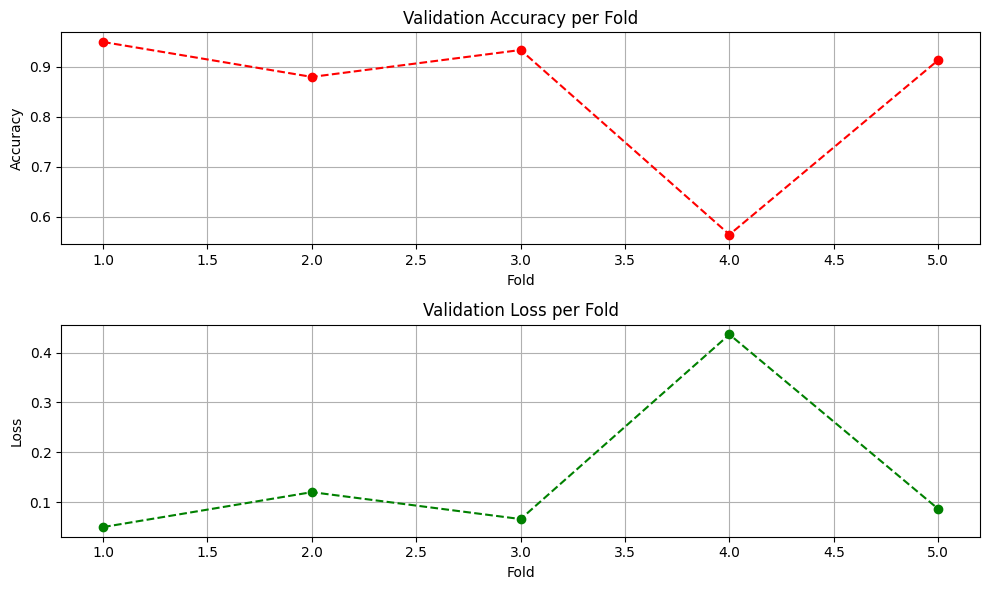

In [70]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(range(1, len(VALIDATION_ACCURACY) + 1), VALIDATION_ACCURACY, marker='o', linestyle='--', color='r')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(range(1, len(VALIDATION_LOSS) + 1), VALIDATION_LOSS, marker='o', linestyle='--', color='green')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()